In [40]:
import os
import astrophot as ap
import numpy as np
import torch
from astropy.io import fits
from astropy.wcs import WCS
import matplotlib.pyplot as plt
from time import time
from glob import glob
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.nddata import Cutout2D
import pandas as pd

In [3]:
import sys
sys.path.append('..')
from multibandphotometry import MultiBandPhotometry

Note: detected 256 virtual cores but NumExpr set to maximum of 64, check "NUMEXPR_MAX_THREADS" environment variable.
Note: NumExpr detected 256 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
NumExpr defaulting to 8 threads.


In [4]:
source_position = SkyCoord(150.15949, 2.1914772, frame='icrs', unit=u.deg)
z = 0.924
phot = MultiBandPhotometry(source_position, z,)

the RADECSYS keyword is deprecated, use RADESYSa.
the RADECSYS keyword is deprecated, use RADESYSa.
the RADECSYS keyword is deprecated, use RADESYSa.
Set DATE-END to '2016-06-04T00:47:19.488' from MJD-END'.
Set DATE-END to '2016-05-03T03:37:16.477' from MJD-END'.
Set DATE-END to '2016-06-29T23:52:46.677' from MJD-END'.
Set DATE-END to '2016-05-03T03:02:47.823' from MJD-END'.
Set DATE-END to '2016-04-30T03:11:04.794' from MJD-END'.


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set DATE-END to '2016-06-04T00:47:19.488' from MJD-END'. [astropy.wcs.wcs]
Set DATE-END to '2016-05-03T03:37:16.477' from MJD-END'. [astropy.wcs.wcs]
Set DATE-END to '2016-06-29T23:52:46.677' from MJD-END'. [astropy.wcs.wcs]
Set DATE-END to '2016-05-03T03:02:47.823' from MJD-END'. [astropy.wcs.wcs]
Set DATE-END to '2016-04-30T03:11:04.794' from MJD-END'. [astropy.wcs.wcs]


## Test model fitting result for a single band

In [4]:
def test_model_fit_one_band(phot, telescope, band, model_type='sersic galaxy model', size=3*u.arcsec):
    telescope_band = '_'.join([telescope, band])
    data = phot.source_cutout(telescope_band,size=size).data.astype(np.float64)
    zeropoint = phot.zeropoints[telescope_band]
    rms_map = phot.load_background(telescope_band)[1]
    rms_cutout = Cutout2D(rms_map, position=phot.source_position, size=size, wcs=phot.wcss[telescope_band])
    wcs = rms_cutout.wcs
    variance = 1./rms_cutout.data.astype(np.float64)**2
    psf = phot.load_psf(telescope_band)

    target = ap.image.Target_Image(
        data = data,
        zeropoint = zeropoint,
        variance = variance, # Here we just use the IQR^2 of the pixel values as the variance, for science data one would use a more accurate variance value
        psf = psf, # we construct a basic gaussian psf for each image by giving the simga (arcsec), image width (pixels), and pixelscale (arcsec/pixel)
        wcs = wcs, # note pixelscale and origin not needed when we have a WCS object!
    )
    model = ap.models.AstroPhot_Model(
        name = f"{band} model",
        model_type = model_type,
        target = target,
        params = { 'Re': {'limits': [0, 1], }, },
        psf_mode = "full",)
    model.initialize()

    fig, ax = plt.subplots(figsize = (8,8))
    ap.plots.target_image(fig, ax, target)
    plt.title(f'{telescope_band} original image')
    plt.show()
    
    fig, ax = plt.subplots(1, 2, figsize = (16,6))
    ap.plots.model_image(fig, ax[0], model)
    ap.plots.residual_image(fig, ax[1], model)
    plt.suptitle(f'{telescope_band} initialized model')
    plt.show()

    result = ap.fit.LM(model, verbose = 0).fit()
    print("Fit message:",result.message)

    fig, ax = plt.subplots(1, 2, figsize = (16,6))
    ap.plots.model_image(fig, ax[0], model)
    ap.plots.residual_image(fig, ax[1], model)
    plt.suptitle(f'{telescope_band} model fitting result')
    plt.show()
    
    

/home/lupengjun/OII_emitter/photometry/code/phot_astrophot/../multibandphotometry.py:311: RuntimeWarning: divide by zero encountered in divide
  rms_map = np.sqrt(1/rms_map) #weight map = 1/sigma***2


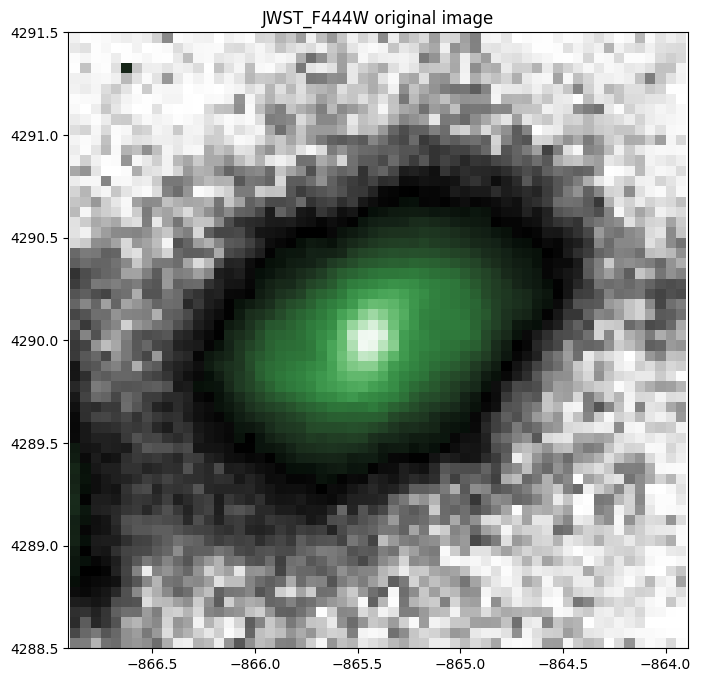

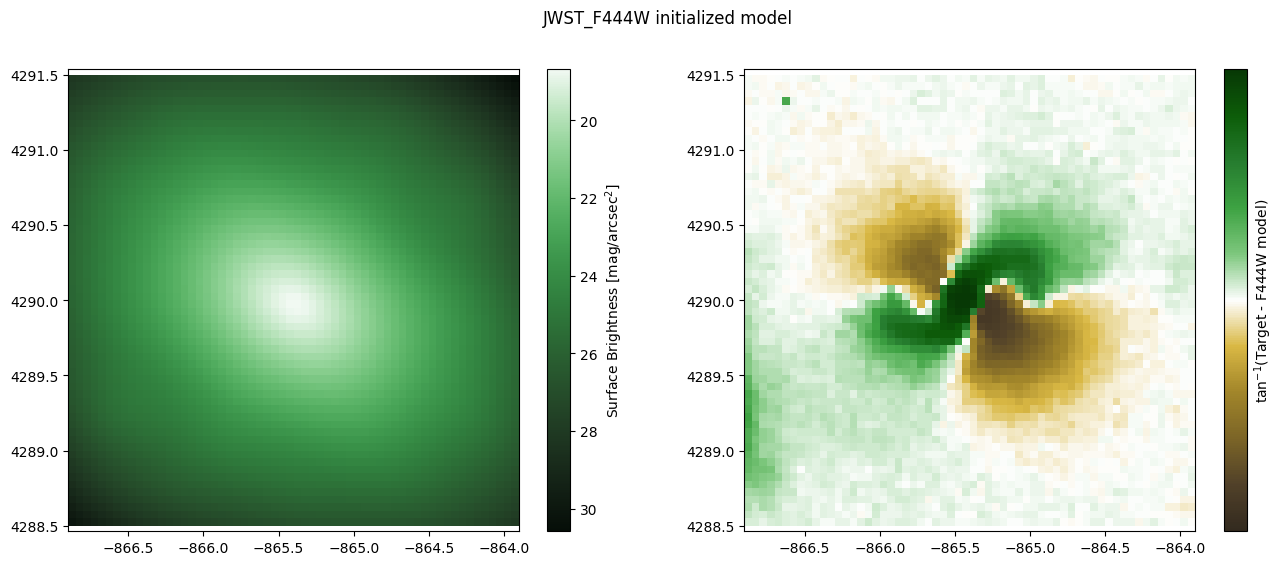

Fit message: success


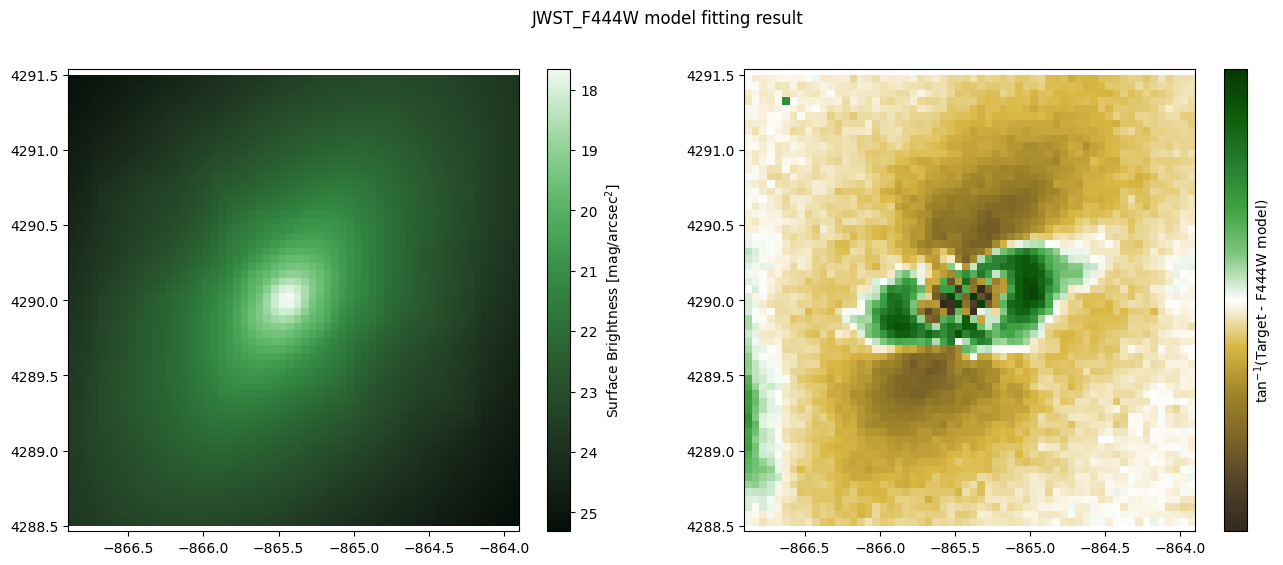

In [5]:
test_model_fit_one_band(phot, 'JWST', 'F444W')

## Construct Joint Modelling

In [7]:
def load_target_images(phot, target_telescope=['HST', 'JWST', 'SUBARU'], size=3*u.arcsec, plot=True):
    target_images = {}
    #reference target
    telescope_band = 'JWST_F150W'
    data = phot.source_cutout(telescope_band,size=size).data.astype(np.float64)
    zeropoint = phot.zeropoints[telescope_band]
    bkg_map, rms_map = phot.load_background(telescope_band)[:2]
    rms_cutout = Cutout2D(rms_map, position=phot.source_position, size=size, wcs=phot.wcss[telescope_band])
    bkg_cutout = Cutout2D(bkg_map, position=phot.source_position, size=size, wcs=phot.wcss[telescope_band])
    wcs = rms_cutout.wcs
    variance = 1./rms_cutout.data.astype(np.float64)**2
    psf = phot.load_psf(telescope_band)
    reference_target = ap.image.Target_Image(
            data = data-bkg_cutout.data.astype(np.float64),
            zeropoint = zeropoint,
            variance = variance,
            psf = psf,
            wcs = wcs
        )
    target_images[telescope_band] = reference_target

    for telescope in target_telescope:
        for band in phot.valid_bands[telescope]:
            telescope_band = '_'.join([telescope, band])
            data = phot.source_cutout(telescope_band,size=size).data.astype(np.float64)
            zeropoint = phot.zeropoints[telescope_band]
            bkg_map, rms_map = phot.load_background(telescope_band)[:2]
            rms_cutout = Cutout2D(rms_map, position=phot.source_position, size=size, wcs=phot.wcss[telescope_band])
            bkg_cutout = Cutout2D(bkg_map, position=phot.source_position, size=size, wcs=phot.wcss[telescope_band])        
            wcs = rms_cutout.wcs
            variance = 1./rms_cutout.data.astype(np.float64)**2
            psf = phot.load_psf(telescope_band)
            if telescope_band == 'JWST_F150W': continue
            else:
                target = ap.image.Target_Image(
                        data = data-bkg_cutout.data.astype(np.float64),
                        zeropoint = zeropoint,
                        variance = variance,
                        psf = psf,
                        wcs = wcs,
                        reference_radec = reference_target.window.reference_radec
                    )
                target_images[telescope_band] = target
    
    if plot:
        nrows = len(target_images)//3+1
        fig, axes = plt.subplots(nrows, 3, figsize=(6,6*nrows))
        axes = axes.flatten()
        for i, telescope_band in enumerate(target_images.keys()):
            ap.plots.target_image(fig, axes[i], target_images[telescope_band], flipx=True)
            axes[i].set_title(f'{telescope_band} image')
            # ymin, ymax = axes[i].get_ylim()
            # axes[i].set_ylim((ymax+2*ymin)/3, ((2*ymax+ymin)/3))
    plt.show()

    return target_images

/home/lupengjun/OII_emitter/photometry/code/phot_astrophot/../multibandphotometry.py:311: RuntimeWarning: divide by zero encountered in divide
  rms_map = np.sqrt(1/rms_map) #weight map = 1/sigma***2
/home/lupengjun/OII_emitter/photometry/code/phot_astrophot/../multibandphotometry.py:311: RuntimeWarning: divide by zero encountered in divide
  rms_map = np.sqrt(1/rms_map) #weight map = 1/sigma***2
/home/lupengjun/OII_emitter/photometry/code/phot_astrophot/../multibandphotometry.py:311: RuntimeWarning: divide by zero encountered in divide
  rms_map = np.sqrt(1/rms_map) #weight map = 1/sigma***2
/home/lupengjun/OII_emitter/photometry/code/phot_astrophot/../multibandphotometry.py:311: RuntimeWarning: divide by zero encountered in divide
  rms_map = np.sqrt(1/rms_map) #weight map = 1/sigma***2
/home/lupengjun/OII_emitter/photometry/code/phot_astrophot/../multibandphotometry.py:311: RuntimeWarning: divide by zero encountered in divide
  rms_map = np.sqrt(1/rms_map) #weight map = 1/sigma***2


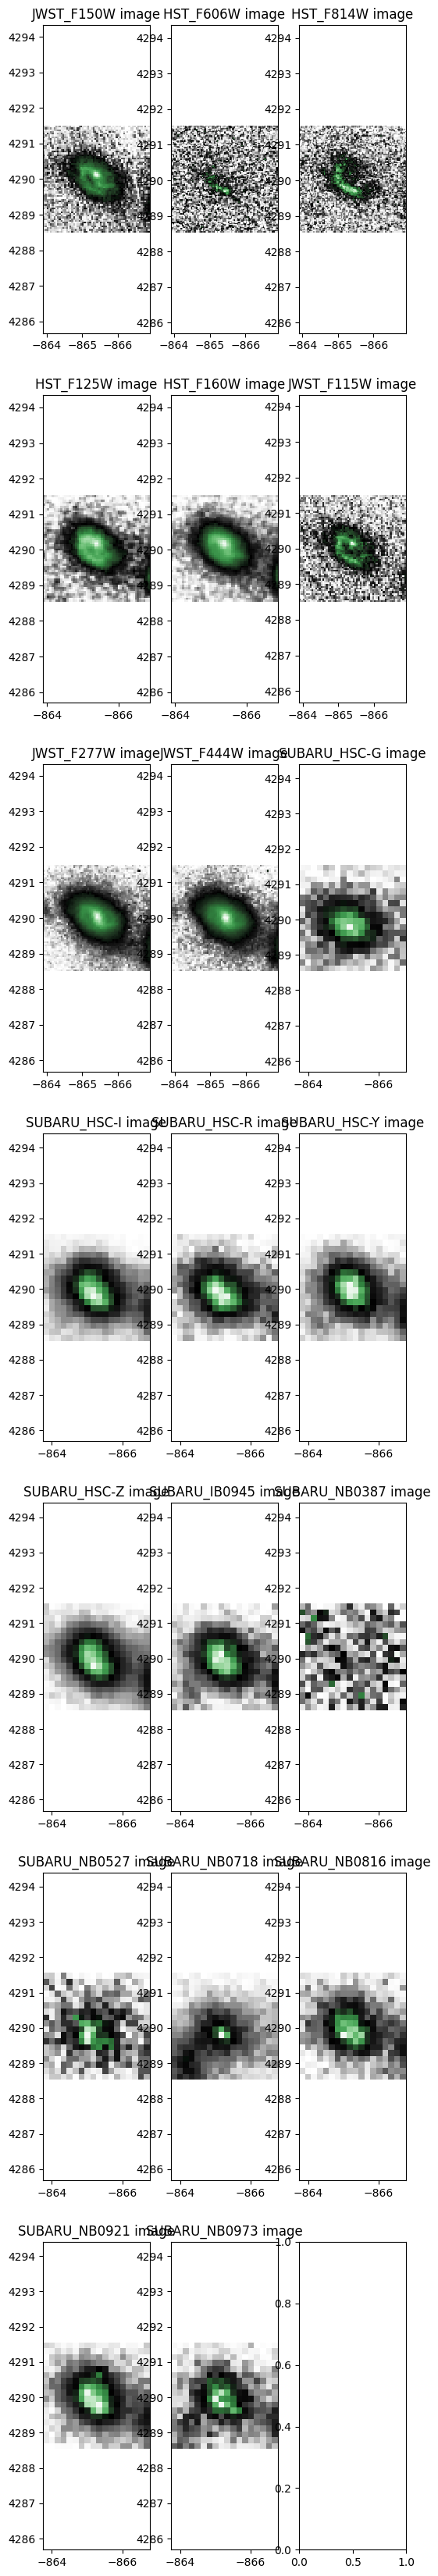

In [8]:
target_images = load_target_images(phot)
target_full = ap.image.Target_Image_List(list(target_images.values()))

In [83]:
def load_models(target_dic, model_type='sersic galaxy model'):
    models = {}
    for telescope_band in target_dic:
        model = ap.models.AstroPhot_Model(
            name = telescope_band,
            model_type = model_type,
            target = target_dic[telescope_band],
            psf_mode = 'full',
        )
        models[telescope_band] = model
    # fix structure parameters while letting brightness parameters vary between bands
    for telescope_band in models.keys():
        if telescope_band == 'JWST_F150W': continue
        else:
#            for p in ["center", "q", "PA", "n", "Re"]:
            for p in ["center", "q", "PA",]:
                models[telescope_band][p].value = models['JWST_F150W'][p]
    return models

In [86]:
model_full = ap.models.AstroPhot_Model(
    name = 'OII_galaxy_warp',
    model_type = 'group model',
    models = list(load_models(target_images, model_type='ray galaxy model').values()),
    target = target_full
)

In [87]:
model_full.initialize()

AttributeError: 'Ray_Galaxy' object has no attribute 'iradial_model'

In [88]:
result = ap.fit.LM(model_full, verbose = 1).fit()
print(result.message)

AttributeError: 'Ray_Galaxy' object has no attribute 'iradial_model'

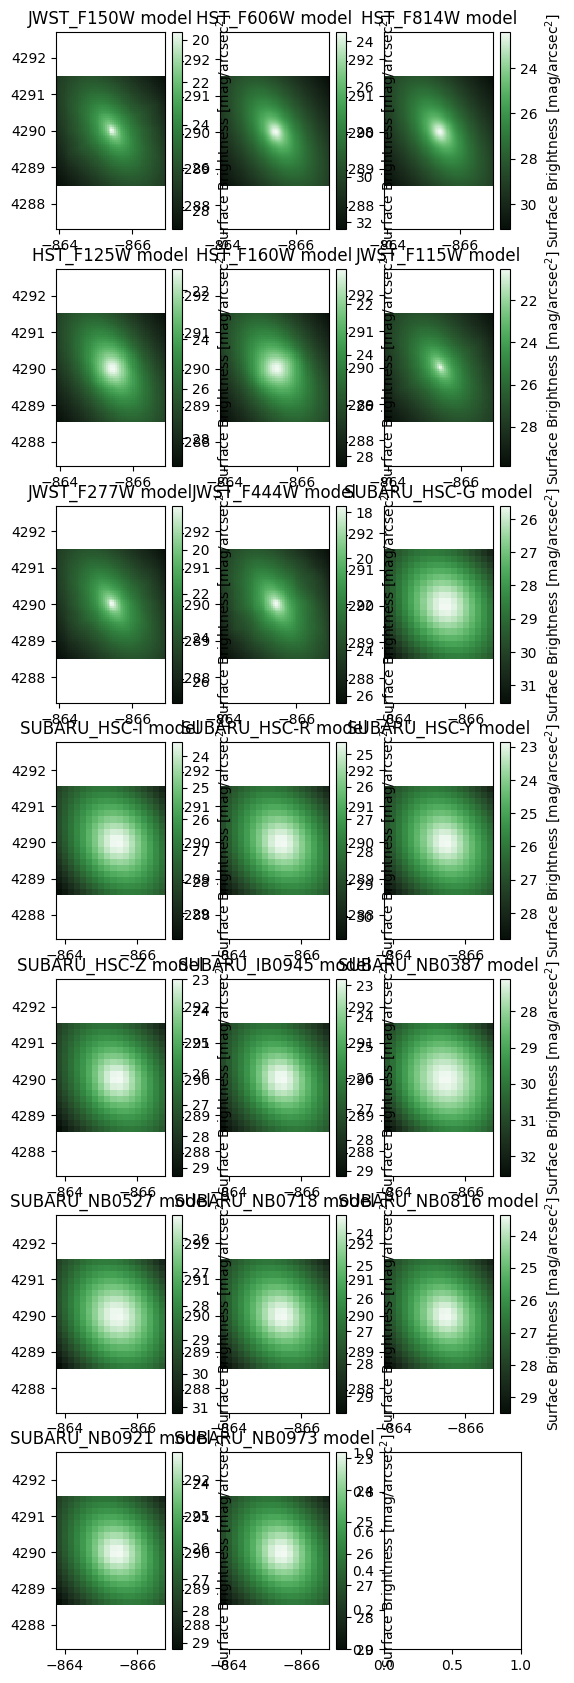

In [13]:
nrows = len(target_images)//3+1
fig, ax = plt.subplots(nrows, 3, figsize = (6, 3*nrows))
ap.plots.model_image(fig, ax.flatten(), model_full, flipx=True)
for i, telescope_band in enumerate(target_images.keys()):
    ax.flatten()[i].set_title(f'{telescope_band} model')
plt.show()

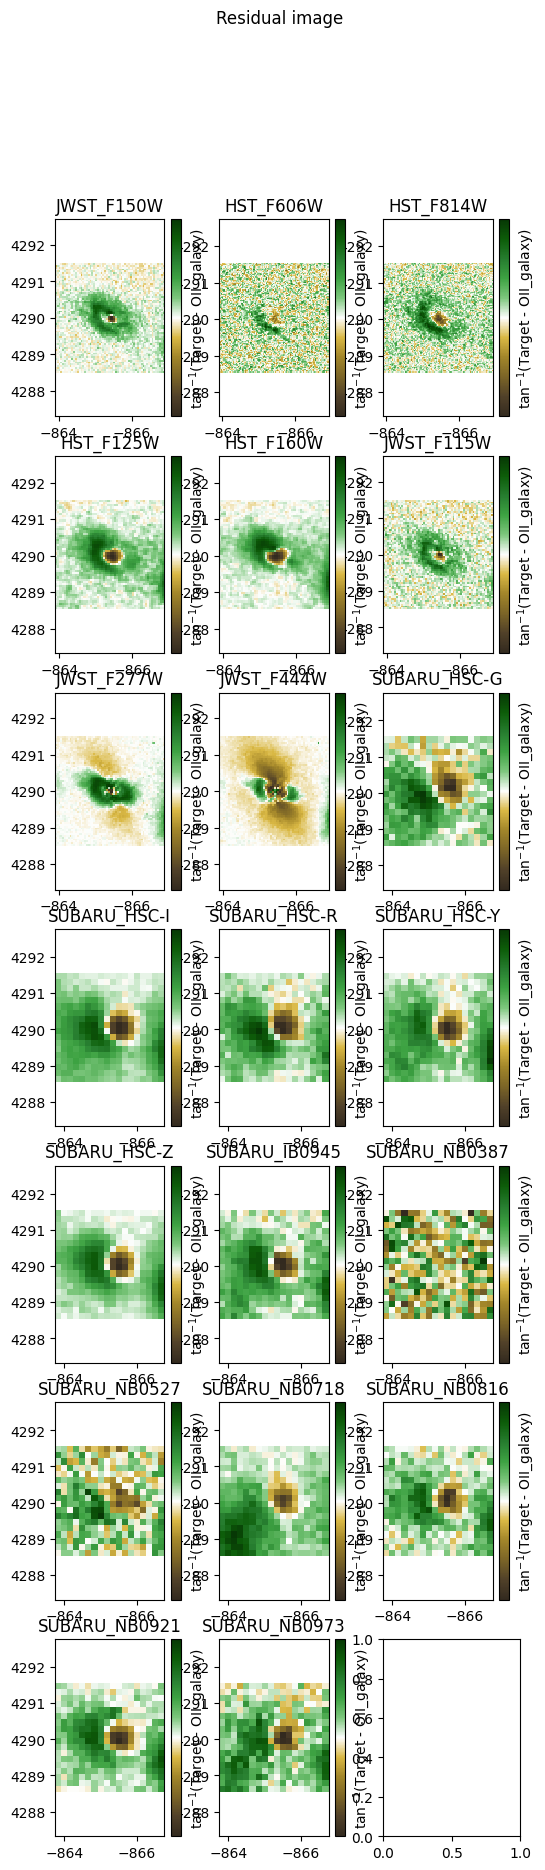

In [14]:
nrows = len(target_images)//3+1
fig, ax = plt.subplots(
nrows, 3, figsize = (6, 3*nrows))
ap.plots.residual_image(fig, ax.flatten(), model_full, flipx=True)
for i, telescope_band in enumerate(target_images.keys()):
    ax.flatten()[i].set_title(f'{telescope_band}')
fig.suptitle('Residual image')
plt.show()

In [18]:
model_full.save("../../output/jointmodels/jointmodels_bkgsub_1026.yaml")

In [20]:
model_full.models['JWST_F150W'].parameters

JWST_F150W (id-139752407811312, branch node):
  center (id-139752407811360): [-865.4425315518151, 4290.010817464239] +- 0.1 [arcsec]
  q (id-139751333272912): 0.502838199495487 +- 0.03 [b/a], limits: (0.0, 1.0)
  PA (id-139751333274832): 2.6030648775698104 +- 0.06 [radians], limits: (0.0, 3.141592653589793), cyclic
  n (id-139754736644544): 3.6073672425428143 +- 0.05 [none], limits: (0.36, 8.0)
  Re (id-139751336221504): 0.47936637878078325 +- 0.014436215829644952 [arcsec], limits: (0.0, None)
  Ie (id-139751334892816): 2.411248276406454 +- 0.032869378557186794 [log10(flux/arcsec^2)]

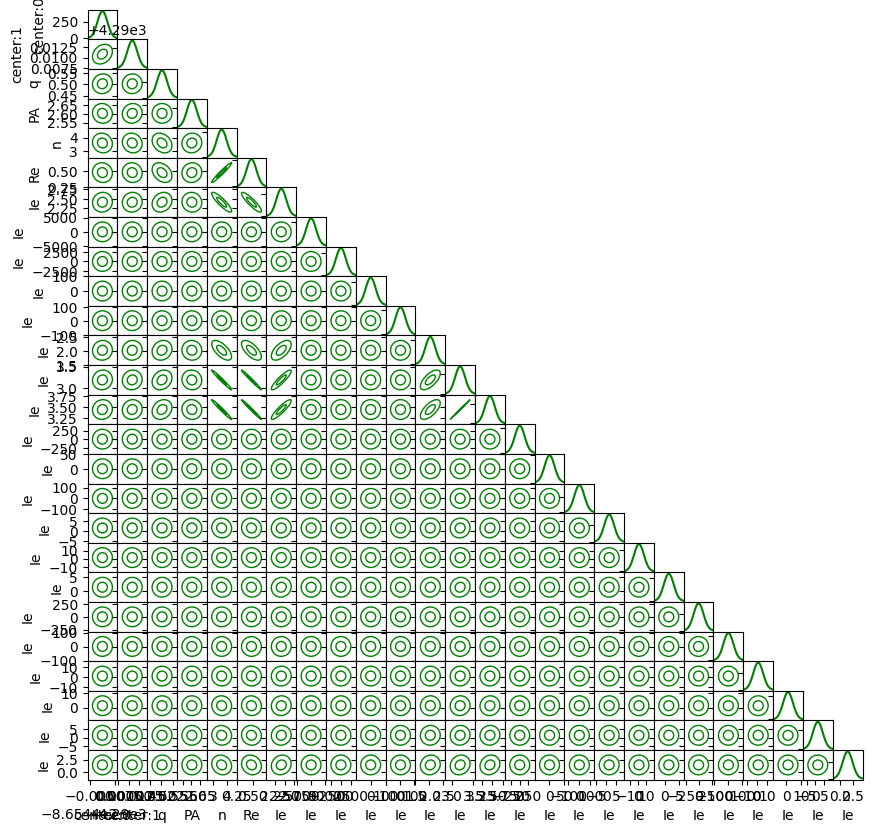

In [19]:
fig, ax = ap.plots.covariance_matrix(
    result.covariance_matrix.detach().cpu().numpy(), 
    model_full.parameters.vector_values().detach().cpu().numpy(), 
    model_full.parameters.vector_names(),
)
plt.show()

In [21]:
model_reload = ap.models.AstroPhot_Model(
    name = 'reload OII galaxy',
    filename = '../../output/jointmodels/jointmodels_bkgsub_1026.yaml'
)

In [34]:
model_full.models[telescope_band].parameters

SUBARU_NB0973 (id-139751333276128, branch node):
  center (id-139751333271328) points to: center (id-139752407811360): [-865.4425315518151, 4290.010817464239] +- 0.1 [arcsec]
  q (id-139751333271280) points to: q (id-139751333272912): 0.502838199495487 +- 0.03 [b/a], limits: (0.0, 1.0)
  PA (id-139751333270656) points to: PA (id-139751333274832): 2.6030648775698104 +- 0.06 [radians], limits: (0.0, 3.141592653589793), cyclic
  n (id-139751333271088) points to: n (id-139754736644544): 3.6073672425428143 +- 0.05 [none], limits: (0.36, 8.0)
  Re (id-139751333278144) points to: Re (id-139751336221504): 0.47936637878078325 +- 0.014436215829644952 [arcsec], limits: (0.0, None)
  Ie (id-139751333278192): 1.4495836374260558 +- 0.03607393074429526 [log10(flux/arcsec^2)]

In [66]:
flux_mag_dic = {}
error_mag_dic = {}
flux_uJy_dic = {}
error_uJy_dic = {}
for telescope_ in phot.valid_bands.keys():
    flux_mag_dic[telescope_]  = {}
    error_mag_dic[telescope_] = {}
    flux_uJy_dic[telescope_]  = {}
    error_uJy_dic[telescope_]  = {}

for telescope_band in model_full.model_names:
    if 'galaxy' in telescope_band: continue
    telescope, band = telescope_band.split('_')
    flux_mag_dic[telescope][band] = -2.5*np.log10(model_full.models[telescope_band].total_flux().detach().cpu().numpy()) + phot.zeropoints[telescope_band]
    error_mag_dic[telescope][band] = -2.5*np.log10(model_full.models[telescope_band].total_flux_uncertainty().detach().cpu().numpy()) + phot.zeropoints[telescope_band]
    flux_uJy_dic[telescope][band] = model_full.models[telescope_band].total_flux().detach().cpu().numpy()*10**((phot.zeropoints[telescope_band]-23.9)/-2.5)
    error_uJy_dic[telescope][band] = model_full.models[telescope_band].total_flux_uncertainty().detach().cpu().numpy()*10**((phot.zeropoints[telescope_band]-23.9)/-2.5)


total flux

$I(R) = I_ee^{-b_n[(R/R_e)^{1/n}-1]}$

total flux uncertainty:

$\sigma_f^2 = \sum_i \left(\frac{df}{dx_i}\sigma_i\right)^2$

In [67]:
flux_uJy_dic

{'HST': {'F606W': 0.2837051713647849,
  'F814W': 0.8638518518003158,
  'F125W': 5.289478305515256,
  'F160W': 10.03117364428228},
 'JWST': {'F150W': 6.4234061830186375,
  'F115W': 2.6700350565932083,
  'F277W': 38.629656199419394,
  'F444W': 69.02984567491018},
 'SUBARU': {'HSC-G': 0.38161662019911724,
  'HSC-I': 2.099111986390392,
  'HSC-R': 0.8157788732757403,
  'HSC-Y': 4.47331741435547,
  'HSC-Z': 3.226620325788726,
  'IB0945': 3.7878395986518236,
  'NB0387': 0.12657748664954876,
  'NB0527': 0.5190384496049857,
  'NB0718': 2.432909312259808,
  'NB0816': 2.5282976202932965,
  'NB0921': 3.3900170331730997,
  'NB0973': 4.037390403789046},
 'CFHT': {},
 'SPITZER': {},
 'GEMINI': {},
 'UKIRT': {},
 'VISTA': {}}

In [68]:
flux_mag_df = pd.DataFrame(flux_mag_dic)
flux_uJy_df = pd.DataFrame(flux_uJy_dic)
error_mag_df = pd.DataFrame(error_mag_dic)
error_uJy_df = pd.DataFrame(error_uJy_dic)


In [75]:
flux_mag_df.to_csv('../../output/flux_sum_mag_sersic_astrophot.csv')
flux_mag_df

,HST,JWST,SUBARU,CFHT,SPITZER,GEMINI,UKIRT,VISTA
F606W,25.267832,NaN,NaN,NaN,NaN,NaN,NaN,NaN
F814W,24.058902,NaN,NaN,NaN,NaN,NaN,NaN,NaN
F125W,22.091468,NaN,NaN,NaN,NaN,NaN,NaN,NaN
F160W,21.396621,NaN,NaN,NaN,NaN,NaN,NaN,NaN
F150W,NaN,21.880587,NaN,NaN,NaN,NaN,NaN,NaN
F115W,NaN,22.833708,NaN,NaN,NaN,NaN,NaN,NaN
F277W,NaN,19.932698,NaN,NaN,NaN,NaN,NaN,NaN
F444W,NaN,19.302408,NaN,NaN,NaN,NaN,NaN,NaN
HSC-G,NaN,NaN,24.945932,NaN,NaN,NaN,NaN,NaN
HSC-I,NaN,NaN,23.094911,NaN,NaN,NaN,NaN,NaN


In [76]:
flux_uJy_df.to_csv('../../output/flux_sum_uJy_sersic_astrophot.csv')
flux_uJy_df

,HST,JWST,SUBARU,CFHT,SPITZER,GEMINI,UKIRT,VISTA
F606W,0.283705,NaN,NaN,NaN,NaN,NaN,NaN,NaN
F814W,0.863852,NaN,NaN,NaN,NaN,NaN,NaN,NaN
F125W,5.289478,NaN,NaN,NaN,NaN,NaN,NaN,NaN
F160W,10.031174,NaN,NaN,NaN,NaN,NaN,NaN,NaN
F150W,NaN,6.423406,NaN,NaN,NaN,NaN,NaN,NaN
F115W,NaN,2.670035,NaN,NaN,NaN,NaN,NaN,NaN
F277W,NaN,38.629656,NaN,NaN,NaN,NaN,NaN,NaN
F444W,NaN,69.029846,NaN,NaN,NaN,NaN,NaN,NaN
HSC-G,NaN,NaN,0.381617,NaN,NaN,NaN,NaN,NaN
HSC-I,NaN,NaN,2.099112,NaN,NaN,NaN,NaN,NaN


In [77]:
error_uJy_df.to_csv('../../output/error_sum_uJy_sersic_astrophot.csv')
error_uJy_df

,HST,JWST,SUBARU,CFHT,SPITZER,GEMINI,UKIRT,VISTA
F606W,1.115707,NaN,NaN,NaN,NaN,NaN,NaN,NaN
F814W,0.614354,NaN,NaN,NaN,NaN,NaN,NaN,NaN
F125W,0.553663,NaN,NaN,NaN,NaN,NaN,NaN,NaN
F160W,0.938410,NaN,NaN,NaN,NaN,NaN,NaN,NaN
F150W,NaN,0.731245,NaN,NaN,NaN,NaN,NaN,NaN
F115W,NaN,1.315657,NaN,NaN,NaN,NaN,NaN,NaN
F277W,NaN,3.352150,NaN,NaN,NaN,NaN,NaN,NaN
F444W,NaN,15.719977,NaN,NaN,NaN,NaN,NaN,NaN
HSC-G,NaN,NaN,0.080917,NaN,NaN,NaN,NaN,NaN
HSC-I,NaN,NaN,0.267748,NaN,NaN,NaN,NaN,NaN


In [72]:
error_uJy_df/flux_uJy_df*100 #error percent

,HST,JWST,SUBARU,CFHT,SPITZER,GEMINI,UKIRT,VISTA
F606W,393.262917,NaN,NaN,NaN,NaN,NaN,NaN,NaN
F814W,71.117938,NaN,NaN,NaN,NaN,NaN,NaN,NaN
F125W,10.467250,NaN,NaN,NaN,NaN,NaN,NaN,NaN
F160W,9.354936,NaN,NaN,NaN,NaN,NaN,NaN,NaN
F150W,NaN,11.384065,NaN,NaN,NaN,NaN,NaN,NaN
F115W,NaN,49.274897,NaN,NaN,NaN,NaN,NaN,NaN
F277W,NaN,8.677659,NaN,NaN,NaN,NaN,NaN,NaN
F444W,NaN,22.772725,NaN,NaN,NaN,NaN,NaN,NaN
HSC-G,NaN,NaN,21.203723,NaN,NaN,NaN,NaN,NaN
HSC-I,NaN,NaN,12.755308,NaN,NaN,NaN,NaN,NaN
